In [1]:
%matplotlib inline

import torch

from torch.autograd import Variable
from torch.nn.init import xavier_normal

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [2]:
BATCH_SIZE = 150

transform = transforms.ToTensor()

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Processing...
Done!


In [50]:
class StackedAutoEncoder(nn.Module):
    """
    Stacked Auto Encoder With Tied Weights
    """
    def __init__(self, input_size, hidden_size=300, coding_size=150):
        super(StackedAutoEncoder, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, coding_size)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.dropout(x)
        hidden1_output = F.elu(self.hidden1(x))
        hidden2_output = F.elu(self.hidden2(hidden1_output))
        hidden3_output = F.elu(F.linear(hidden2_output,
                                       weight=self.hidden2.weight.transpose(0,1)))
        output = F.linear(hidden3_output, weight=self.hidden1.weight.transpose(0,1))
        return output, hidden2_output

In [51]:
sae = StackedAutoEncoder(input_size=28*28)

In [52]:
criterion = nn.MSELoss()
optimizer = optim.Adam(sae.parameters(), weight_decay=1e-5)

In [53]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [54]:
N_EPOCHS = 3
total_loss = 0
print_every = 20000 // BATCH_SIZE
plot_every = 1000 // BATCH_SIZE
all_losses = []
iter = 1

start = time.time()

for e in range(N_EPOCHS):
    for i_batch, batch in enumerate(trainloader):
        image = batch[0]
        label = batch[1]
        image = Variable(image.view(-1, 1, 28*28))
        
        sae.zero_grad()
        output, coding = sae(image)
        loss = criterion(output, image)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(trainloader) * N_EPOCHS) * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        iter = iter + 1

0m 1s (133 11%) 0.0217
0m 3s (266 22%) 0.0182
0m 5s (399 33%) 0.0157
0m 7s (532 44%) 0.0154
0m 9s (665 55%) 0.0149
0m 11s (798 66%) 0.0146
0m 13s (931 77%) 0.0139
0m 15s (1064 88%) 0.0141
0m 17s (1197 99%) 0.0143


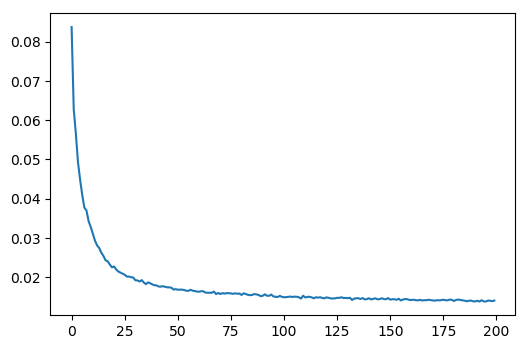

In [55]:
plt.plot(all_losses)

In [56]:
n = 1
for i, batch in enumerate(testloader):
    if i >= n:
        break
    image = batch[0]
    label = batch[1]
    image = Variable(image.view(-1, 1, 28*28))
    output, coding = sae(image)
    outputs = output.data.cpu().numpy()

Text(0.5,1,'Actual')

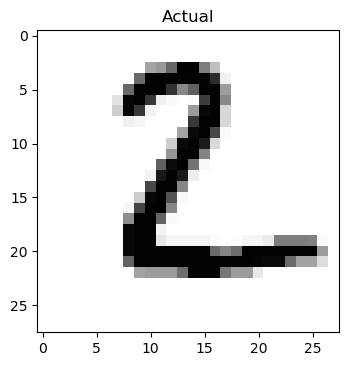

In [57]:
index = 1
plt.imshow(image[index].data.cpu().numpy().reshape(28,28),
          cmap="Greys", interpolation="nearest")
plt.title("Actual")

Text(0.5,1,'Reconstructed')

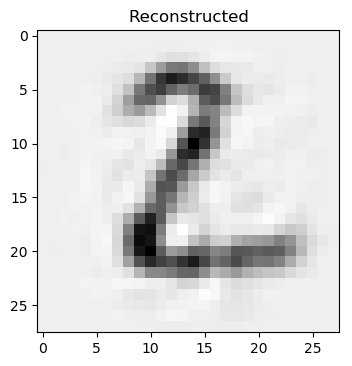

In [58]:
plt.imshow(outputs[index].reshape(28,28),cmap="Greys")
plt.title("Reconstructed")

## Visualizing Features

In [59]:
hidden1_weights = sae.hidden1.weight.data.cpu().numpy()

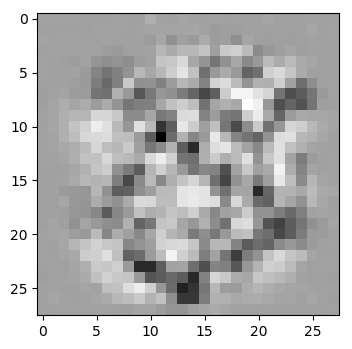

In [61]:
neuron = 3
plt.imshow(hidden1_weights[neuron].reshape([28,28]),
           cmap='Greys')